In [1]:
!pip install datasets

# **1. LIBRARIES**

In [12]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

# **2. DATA PREPROCESSING**

In [3]:
dataset = load_dataset("Ammok/apple_stock_price_from_1980-2021")
df = pd.DataFrame(dataset["train"])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600
...,...,...,...,...,...,...,...
10463,2022-06-13,132.869995,135.199997,131.440002,131.880005,131.880005,122207100
10464,2022-06-14,133.130005,133.889999,131.479996,132.759995,132.759995,84784300
10465,2022-06-15,134.289993,137.339996,132.160004,135.429993,135.429993,91533000
10466,2022-06-16,132.080002,132.389999,129.039993,130.059998,130.059998,108123900


**NOTE:** Dataset `apple_stock_price_from_1980-2021` berasal dari HuggingFace.

https://huggingface.co/datasets/Ammok/apple_stock_price_from_1980-2021


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


## **2.1 Data Normalization**

In [5]:
# Selecting the 'Close' price for modeling
data = df['Close'].values.reshape(-1, 1)

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

> Menggunakan atribut harga `Close` untuk *time series modelling* karena harga `Close` (harga saham saat pasar tutup) itu penting karena memberikan gambaran umum bagaimana kondisi saham setelah sehari penuh berdagang. Ibaratkan, harga `Close` adalah rangkuman dari semua yang terjadi selama suatu hari tertentu, yaitu termasuk reaksi investor terhadap berita atau peristiwa apapun. Yang mana, jika dibandingkan dengan harga `Open` (pembukaan) atau harga `High` (tertinggi)/`Low` (terendah), harga `Close` (penutupan) lebih stabil. Jadi, jika menggunakan harga `Close` untuk melakukan prediksi, hasilnya lebih dapat diandalkan dan tidak terlalu banyak *noise*.

## **2.2 Data Splitting**

In [6]:
# Splitting the data into training and validation sets (80% train, 20% validation)
train_data, val_data = train_test_split(scaled_data, test_size=0.20, shuffle=False)

# Function to create a dataset with time steps
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)

# Reshaping input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

X_train.shape, X_val.shape

((8273, 100, 1), (1993, 100, 1))

# **3. DATA MODELLING**

## **3.1 Data Training**

In [8]:
# Building the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(100, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# EarlyStopping and ReduceLROnPlateau callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

optimizer = Adam(learning_rate=0.001)
# Compiling the model with an optimizer that includes a learning rate
model.compile(optimizer=optimizer, metrics=["mae"], loss=tf.keras.losses.Huber())

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stop, reduce_lr], verbose=1)

Epoch 1/100
259/259 [==============================] - 9s 15ms/step - loss: 8.1686e-06 - mae: 0.0018 - val_loss: 7.5926e-04 - val_mae: 0.0228 - lr: 0.0010
Epoch 2/100
259/259 [==============================] - 3s 11ms/step - loss: 1.6865e-06 - mae: 0.0012 - val_loss: 5.2965e-04 - val_mae: 0.0185 - lr: 0.0010
Epoch 3/100
259/259 [==============================] - 3s 11ms/step - loss: 1.3798e-06 - mae: 0.0011 - val_loss: 6.1110e-04 - val_mae: 0.0201 - lr: 0.0010
Epoch 4/100
259/259 [==============================] - 3s 11ms/step - loss: 1.1979e-06 - mae: 9.9438e-04 - val_loss: 7.8477e-04 - val_mae: 0.0237 - lr: 0.0010
Epoch 5/100
259/259 [==============================] - 3s 11ms/step - loss: 1.3835e-06 - mae: 0.0011 - val_loss: 4.9355e-04 - val_mae: 0.0178 - lr: 0.0010
Epoch 6/100
259/259 [==============================] - 3s 11ms/step - loss: 1.1074e-06 - mae: 9.6556e-04 - val_loss: 3.9517e-04 - val_mae: 0.0160 - lr: 0.0010
Epoch 7/100
259/259 [==============================] - 3s 11ms

## **3.2 Model Evaluation**

In [11]:
# Making predictions
predicted = model.predict(X_val)

# Inverting the normalization for true scale MAE
predicted_actual = scaler.inverse_transform(predicted)
y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))

# Calculating MAE
mae = mean_absolute_error(y_val_actual, predicted_actual)
print("Mean Absolute Error:", mae)

# Checking if MAE is less than 10% of the data scale
data_scale = df['Close'].max() - df['Close'].min()
print("MAE < 10% of data scale:", mae < 0.1 * data_scale)

63/63 [==============================] - 0s 5ms/step
Mean Absolute Error: 1.6233130016221935
MAE < 10% of data scale: True


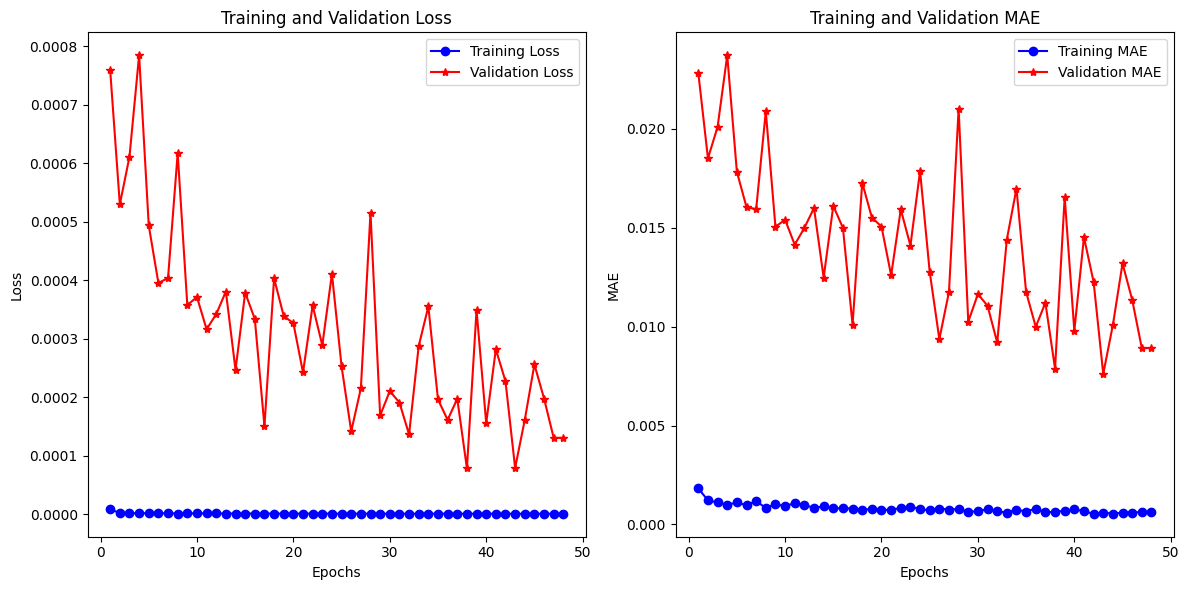

In [13]:
# Extracting loss and MAE from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = range(1, len(loss) + 1)

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'bo-', label='Training MAE')
plt.plot(epochs, val_mae, 'r*-', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()